# Introduction.
What is KD, importance, why we need to learn from it, why is expect of the members to get.
Requirements needed etc.

#### Student model

We design a lightweight model with <a href="https://arxiv.org/pdf/1602.07360">SquuezeNet backbone</a> pretrained to extarct features from the an images. WSo we just remove tthe classification tail of the model and add a custom backbone for generating heatmaps.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from collections import namedtuple

KeypointOutput = namedtuple('KeypointOutput', [' <aheatmaps'])
class SqueezeNetHPE(nn.Module):
    def __init__(self, num_keypoints=17):
        super().__init__()
        squeezenet = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)
        self.backbone = squeezenet.features
        self.relu = nn.ReLU(inplace=True)
        self.conv_heatmap = nn.Conv2d(
            in_channels=512,
            out_channels=num_keypoints,
            kernel_size=3,
            padding=1
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.relu(x)
        x = F.interpolate(
            x,
            size=(96, 72), 
            mode="bilinear",
            align_corners=False
        )
        heatmaps = self.conv_heatmap(x)

        return KeypointOutput(heatmaps=heatmaps)



#### Teacher model


In this tutprial we will use <a href="https://github.com/HRNet/HRNet-Human-Pose-Estimation?tab=readme-ov-file"> HR-net pose model </a>

In [7]:
import torch
import os
from hrnet_pose.hrnetpose_model import get_pose_net
from hrnet_pose.configs import load_configs

cfg = load_configs('hrnet_pose/hrnet_w48_model_configs.yaml')
teacher_model = get_pose_net(cfg, is_train=False)

path = 'hrnet_pose/hrnet_pose_models/pose_hrnet_w48_384x288.pth'

try:
    checkpoint = torch.load(path, map_location='cpu', weights_only=False)
except Exception:
    with open(path, 'r') as f:
        print(f"FILE CONTENT START: {f.read(100)}")
    raise RuntimeError("The .pth file is a text pointer, not a real model file. Download the 'Raw' file from GitHub.")

if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    teacher_model.load_state_dict(checkpoint['state_dict'])
else:
    teacher_model.load_state_dict(checkpoint)

teacher_model.eval()

print("Model successfully initialized.")

FILE CONTENT START: version https://git-lfs.github.com/spec/v1
oid sha256:95e0fec3194826d5e3f806ea89be68bbb84517b114c3a3


RuntimeError: The .pth file is a text pointer, not a real model file. Download the 'Raw' file from GitHub.

### Dataset

In this tutorial, we will use <a href="https://cocodataset.org/#keypoints-2017"> COCO 2017 keypoint dataset</a> and use <a href="https://docs.voxel51.com/#where-to-begin"> fiftyone </a> for access and visualization of the the dataset.

#### 1. Accessing using fiftyone

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

/home/clinton-mwangi/Desktop/projects/2d-human-pose-estimation-using-kd/kd_hpe_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
coco2017_train = foz.load_zoo_dataset("coco-2017", split='train',max_samples=30000,  label_types=["person_keypoints"])

Found annotations at '/home/clinton-mwangi/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-30000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
coco2017_val = foz.load_zoo_dataset("coco-2017", split='validation')

Found annotations at '/home/clinton-mwangi/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
coco2017_val

Name:        coco-2017-validation
Media type:  image
Num samples: 5000
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [ ]:
session = fo.launch_app(coco2017_train, auto=False)


Session launched. Run `session.show()` to open the App in a cell output.


#### 2. Direct download

In [21]:
# Path to store the data
!mkdir -p /capstor/scratch/cscs/ckuya/coco_data /capstor/scratch/cscs/ckuya/coco_data/annotations 

!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /capstor/scratch/cscs/ckuya/coco_data/
!wget -c http://images.cocodataset.org/zips/val2017.zip -P /capstor/scratch/cscs/ckuya/coco_data/
!wget -c http://images.cocodataset.org/zips/train2017.zip -P /capstor/scratch/cscs/ckuya/coco_data/


--2026-01-31 07:29:55--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.200.48, 3.5.31.10, 52.217.116.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.200.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/capstor/scratch/cscs/ckuya/coco_data/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  35.1MB/s    in 7.8s    

2026-01-31 07:30:03 (31.1 MB/s) - ‘/capstor/scratch/cscs/ckuya/coco_data/annotations_trainval2017.zip’ saved [252907541/252907541]

--2026-01-31 07:30:10--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.110, 3.5.25.28, 52.217.172.225, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [ ]:
!unzip  /capstor/scratch/cscs/ckuya/coco_data/annotations_trainval2017.zip -d /capstor/scratch/cscs/ckuya/coco_data/annotations/
# !unzip -q /capstor/scratch/cscs/ckuya/coco_data/val2017.zip -d /capstor/scratch/cscs/ckuya/coco_data/
# !unzip -q coco/train2017.zip -d /capstor/scratch/cscs/ckuya/coco_data/

# Cleanup zip files
# !rm -rf coco/*.zip

### Data Prepocessing

Since some images dont have person and may not have kkeypoint annotations we need to process the images.

Processing that is required.

Take the image, check if there is a person by checking the number of keypoints in the annotation greater than zero.
If we get the image we process it and then find the person, we cropp it and transform the person annocation into the required space.
Take the keypoints and then generate the heatmaps for the graound truth.

In [ ]:
import numpy as np
from typing import List, Tuple, Union
import cv2

def extract_keypoints_and_visibility(keypoints: List[float]):
    try:
        kps_array = np.array(keypoints, dtype=np.float32).reshape(-1, 3)
        coords = kps_array[:,:2]
        visibility = kps_array[:,2]

        return coords, visibility.astype(np.int32)

    except Exception as e:
        print(f"Error extracting keypoints and visibility: {e}")
        raise e


def process_image_and_keypoints(
    image: np.ndarray,
    keypoints: Union[List[List[float]], np.ndarray],
    bbox: Union[List[int], Tuple[int, int, int, int]],
    target_size: Tuple[int, int],
    angle: float = 0,
    flip: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Crop, resize, rotate, and optionally flip an image and its corresponding keypoints
    for pose estimation tasks.

    Steps:
        1. Crop the image using the bounding box and clamp to image bounds.
        2. Shift keypoints relative to the crop coordinates.
        3. Mask keypoints outside the crop.
        4. Resize the image and scale keypoints to the target size.
        5. Rotate image and keypoints if angle != 0.
        6. Flip image horizontally if flip=True.
        7. Restore [0, 0] for originally invisible or out-of-bounds keypoints.

    Args:
        image (np.ndarray): Input image of shape (H, W, C).
        keypoints (list or np.ndarray): Keypoints of shape (N, 2) or single keypoint (2,).
        bbox (list or tuple): Bounding box [x, y, w, h] for cropping.
        target_size (tuple): Desired output size (width, height) after resizing.
        angle (float, optional): Rotation angle in degrees. Default is 0.
        flip (bool, optional): Whether to horizontally flip the image. Default is False.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - resized_image: Processed image of shape (target_height, target_width, C)
            - keypoints: Transformed keypoints of shape (N, 2)

    Raises:
        ValueError: If keypoints array is not in expected shape.
    """
    try:

        x1, y1, w, h = np.round(bbox).astype(int)
        img_h, img_w = image.shape[:2]

        cx1, cy1 = max(0, x1), max(0, y1)
        cx2, cy2 = min(img_w, x1 + w), min(img_h, y1 + h)

        # Step 1: Crop
        image = image[cy1:cy2, cx1:cx2]
        crop_h, crop_w = image.shape[:2]

        # Step 2: Prepare Keypoints (N, 2)
        kps = np.ascontiguousarray(keypoints, dtype=np.float32).reshape(-1, 2)

        zero_mask = np.all(kps == 0, axis=1)
        kps -= [cx1, cy1]

        # Step 3:Masking
        invalid_mask = (kps[:, 0] < 0) | (kps[:, 1] < 0) | (kps[:, 0] >= crop_w) | (kps[:, 1] >= crop_h)

        # Step 4: Resize (Image and KPs together)
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        kps *= [target_size[0] / crop_w, target_size[1] / crop_h]

        # Step 5: Rotation 
        if angle != 0:
            center = (target_size[0] / 2, target_size[1] / 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            image = cv2.warpAffine(image, M, target_size)
            kps = kps @ M[:, :2].T + M[:, 2]

        # Step 6: Horizontal Flip
        if flip:
            image = cv2.flip(image, 1)
            kps[:, 0] = target_size[0] - kps[:, 0]

        # Step 7: Final Restoration
        kps[zero_mask | invalid_mask] = 0

        return image, kps
    except Exception as e:
        print(f"Error in process_image_and_keypoints: {e}")
        raise e




In [ ]:
key_dummy =[24,57,2,33,45,2,45,67,2,78,89,2,100,90,2]
key,vs = extract_keypoints_and_visibility(key_dummy)
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("pose.jpg")
ig_n = np.array(img)
plt.imshow(ig_n)


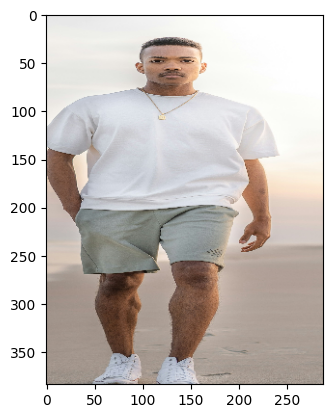

In [ ]:
bbox = [1500, 1500, 1200, 3300]
target_type = (288, 384)

imgt, keyos = process_image_and_keypoints(ig_n, key, bbox, target_type)
plt.imshow(imgt)

#### Heatmaps

In this case, we are going to use heatmaps.

<b> Coordinate Scaling </b>

Let the input image dimensions be $(w, h)$ and the target heatmap dimensions be $(W, H)$. The scaling factors $s$ are defined as:
$$s_x = \frac{W - 1}{w - 1}, \quad s_y = \frac{H - 1}{h - 1}$$

The transformed keypoint coordinates $(x_{hm}, y_{hm})$ are:
$$x_{hm} = x \cdot s_x, \quad y_{hm} = y \cdot s_y$$

<b> Gaussian Distribution </b>

For each keypoint $k \in \{1, \dots, K\}$, the heatmap value at pixel $(i, j)$ is computed using a 2D Gaussian kernel with standard deviation $\sigma$:
$$H_k(i, j) = \exp\left( -\frac{(i - x_{hm,k})^2 + (j - y_{hm,k})^2}{2\sigma^2} \right)$$
where $i \in \{0, \dots, W-1\}$ and $j \in \{0, \dots, H-1\}$.


<b> Visibility Masking </b>

The validity of each heatmap is governed by the visibility flag $v_k$ and boundary constraints. The mask $M_k$ is defined as:
$$M_k = \mathbb{I}(v_k \geq 0.5) \cdot \mathbb{I}(0 \leq x_{hm,k} < W) \cdot \mathbb{I}(0 \leq y_{hm,k} < H)$$
where $\mathbb{I}(\cdot)$ is the indicator function.

In [ ]:
import numpy as np
import torch

def generate_heatmaps(
    keypoints: np.ndarray,
    keypoints_visible: np.ndarray,
    input_size: Tuple[int, int],
    heatmap_size: Tuple[int, int] = (72, 96),
    sigma: float = 2.0,
) -> Tuple[torch.Tensor, torch.Tensor]:

    W, H = heatmap_size
    w, h = input_size
    K = keypoints.shape[0]

    # 1. Vectorized Scaling
    scale = np.array([(W - 1) / (w - 1), (H - 1) / (h - 1)], dtype=np.float32)
    kps_hm = keypoints * scale  # Shape (K, 2)

    # 2. Create Visibility Mask
    # Valid if visible (>0.5) AND within heatmap boundaries
    mask = (keypoints_visible >= 0.5) & \
           (kps_hm[:, 0] >= 0) & (kps_hm[:, 0] < W) & \
           (kps_hm[:, 1] >= 0) & (kps_hm[:, 1] < H)
    mask = mask.astype(np.float32)

    # 3. Pre-compute Grid (Only once!)
    # xx, yy shape: (H, W)
    yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

    # 4. Vectorized Gaussian (Broadcasting Magic)
    # Reshape kps for broadcasting: (K, 1, 1)
    mu_x = kps_hm[:, 0, np.newaxis, np.newaxis]
    mu_y = kps_hm[:, 1, np.newaxis, np.newaxis]

    # Calculate (x - mu_x)^2 + (y - mu_y)^2 for all K at once
    # Resulting shape: (K, H, W)
    dist_sq = (xx - mu_x) ** 2 + (yy - mu_y) ** 2

    heatmaps = np.exp(-dist_sq / (2 * sigma**2))

    # 5. Apply visibility mask to zero out invalid heatmaps
    heatmaps *= mask[:, np.newaxis, np.newaxis]

    return torch.from_numpy(heatmaps), torch.from_numpy(mask)

In [ ]:
input_size = (288, 384)
gt_yf, maskbd = generate_heatmaps(key,vs,input_size)

In [ ]:
maskbd.shape

torch.Size([5])

#### Dataloader

In [ ]:
import logging
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from torch import Tensor
from typing import Optional, Callable
import os

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def get_downloaded_image_ids(root_dir: str, coco: COCO) -> List[int]:
    """Fast set-based intersection to find existing images."""
    on_disk = set(os.listdir(root_dir))
    all_img_info = coco.loadImgs(coco.getImgIds())
    existing_ids = [info['id'] for info in all_img_info if info['file_name'] in on_disk]
    return existing_ids

class CocoKeypoints(Dataset):
    def __init__(self, root: str, annFile: str, target_size=(288, 384), heatmap_size=(72, 96)) -> None:
        self.root = root
        self.coco = COCO(annFile)
        self.target_size = target_size
        self.heatmap_size = heatmap_size

        img_ids = get_downloaded_image_ids(self.root, self.coco)
        self.valid_anns = []

        for img_id in img_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                if ann.get("num_keypoints", 0) > 0:
                    self.valid_anns.append((img_id, ann))

        logger.info(f"Initialized {len(self.valid_anns)} person samples.")

    def __len__(self) -> int:
        return len(self.valid_anns)

    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor, Tensor]:
        img_id, target = self.valid_anns[index]

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info["file_name"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 1. Extract
        coords, visibility = extract_keypoints_and_visibility(target["keypoints"])

        # 2. Process
        processed_img_np, processed_kps = process_image_and_keypoints(
            image, coords, target["bbox"], self.target_size
        )

        # 3. Heatmaps (Using internal HM scaling)
        # Coordinate scaling for heatmap
        hm_scale = [ (self.heatmap_size[0]-1)/(self.target_size[0]-1),
                     (self.heatmap_size[1]-1)/(self.target_size[1]-1) ]
        kps_hm = processed_kps * hm_scale

        heatmaps, masks = generate_heatmaps(kps_hm, visibility, self.heatmap_size)

        # 4. Final Image Tensor [C, H, W]
        img_tensor = torch.from_numpy(processed_img_np).permute(2, 0, 1).float() / 255.0

        return img_tensor, heatmaps, masks


def collate_fn(batch):
    imgs, hms, masks = zip(*batch)
    return torch.stack(imgs), torch.stack(hms), torch.stack(masks)

def get_coco_dataloaders(root_train, ann_train, root_val, ann_val, batch_size=32, num_workers=8):
    train_dataset = CocoKeypoints(root_train, ann_train)
    val_dataset = CocoKeypoints(root_val, ann_val)
    loader_args = dict(
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        persistent_workers=True
    )

    return (
        DataLoader(train_dataset, shuffle=True, **loader_args),
        DataLoader(val_dataset, shuffle=False, **loader_args)
    )


In [ ]:
root_train = "/home/clinton-mwangi/fiftyone/coco-2017/train/data"
root_val = "/home/clinton-mwangi/fiftyone/coco-2017/validation/data"
ann_train = "/home/clinton-mwangi/fiftyone/coco-2017/raw/person_keypoints_train2017.json"
ann_val = "/home/clinton-mwangi/fiftyone/coco-2017/raw/person_keypoints_val2017.json"

train_loader, val_loader = get_coco_dataloaders(
    root_train=root_train,
    ann_train=ann_train,
    root_val=root_val,
    ann_val=ann_val,
    batch_size=8,
    num_workers=4
)

loading annotations into memory...
Done (t=5.77s)
creating index...


2026-01-31 08:58:11,678 - INFO - Initialized 38151 person samples.


index created!
loading annotations into memory...


2026-01-31 08:58:11,966 - INFO - Initialized 6352 person samples.


Done (t=0.24s)
creating index...
index created!


In [ ]:
for imgb, gt_ht, mask_f in train_loader:
    break

/home/clinton-mwangi/Desktop/projects/2d-human-pose-estimation-using-kd/kd_hpe_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


In [ ]:
gt_ht.shape

torch.Size([8, 17, 96, 72])

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from collections import namedtuple

KeypointOutput = namedtuple('KeypointOutput', ['heatmaps'])
class SqueezeNetHPE(nn.Module):
    def __init__(self, num_keypoints=17):
        super().__init__()
        squeezenet = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)
        self.backbone = squeezenet.features
        self.relu = nn.ReLU(inplace=True)
        self.conv_heatmap = nn.Conv2d(
            in_channels=512,
            out_channels=num_keypoints,
            kernel_size=3,
            padding=1
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.relu(x)
        x = F.interpolate(
            x,
            size=(96, 72),
            mode="bilinear",
            align_corners=False
        )
        heatmaps = self.conv_heatmap(x)

        return KeypointOutput(heatmaps=heatmaps)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = SqueezeNetHPE(num_keypoints=17).to(device)

In [ ]:
for img, gt_heatmps, mas in train_loader:
    break

In [ ]:
gt_heatmps.shape

torch.Size([8, 17, 96, 72])

In [ ]:
out_s = student_model(img)

In [ ]:
out_s.heatmaps.shape

torch.Size([8, 17, 96, 72])

### Training and distillation

#### Student training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaptiveWingLoss(nn.Module):
    def __init__(
        self,
        omega: float = 14.0,
        theta: float = 0.5,
        epsilon: float = 1.0,
        alpha: float = 2.1,
        weight: float = 10.0,
    ):
        super().__init__()
        self.omega = omega
        self.theta = theta
        self.epsilon = epsilon
        self.alpha = alpha
        self.weight = weight
        # Pre-calculate constant to save a division in every forward pass
        self.inv_epsilon = 1.0 / epsilon

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        # 1. Direct absolute difference
        delta = (pred - target).abs()

        # 2. Extract shared terms to avoid redundant exponentiation
        # Target influences the exponent, making the loss 'adaptive'
        y_pow = self.alpha - target

        # Calculate (theta / epsilon)^(y_pow) once
        # Using a variable to store this prevents calculating it 3+ times
        theta_eps_pow = torch.pow(self.theta * self.inv_epsilon, y_pow)

        # 3. Calculate A and C coefficients
        # These define the linear part of the loss for errors > theta
        A = (self.omega * (1.0 / (1.0 + theta_eps_pow))
             * y_pow * torch.pow(self.theta * self.inv_epsilon, y_pow - 1.0)
             * self.inv_epsilon)

        # log1p is more efficient and stable than log(1 + x)
        C = self.theta * A - self.omega * torch.log1p(theta_eps_pow)

        # 4. Piecewise Logic: Non-linear for small errors, Linear for large
        # This is where the 'Wing' shape comes from
        losses = torch.where(
            delta < self.theta,
            self.omega * torch.log1p(torch.pow(delta * self.inv_epsilon, y_pow)),
            A * delta - C
        )

        # 5. Spatial Importance Weighting
        # We dilate the target to give extra weight to pixels near the keypoint
        with torch.no_grad():
            Hd = F.max_pool2d(target, kernel_size=3, stride=1, padding=1)
            # Mask where keypoint influence is strong
            importance_mask = (Hd >= 0.2).to(pred.dtype)

        # Apply the weight: (10 * Mask + 1)
        # Keypoint pixels get 11x the gradient of background pixels
        weighted_losses = losses * (self.weight * importance_mask + 1.0)

        return weighted_losses.mean()

#### Evaluation Training

### Knowledge distillation

#### Training loop

In [ ]:
import os
import gc
from typing import Dict, List

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# --------------------
# Config
# --------------------
epochs = 3
lr = 5e-4
weight_decay = 1e-5
save_dir = "./models"

os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = student_model.to(device)

# --------------------
# Optimizer / Scheduler / Loss
# --------------------
optimizer = optim.AdamW(
    student_model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[20, 27],  # harmless even if epochs < milestones
    gamma=0.1,
)

criterion = AdaptiveWingLoss()

scaler = GradScaler(enabled=torch.cuda.is_available())

# --------------------
# Tracking
# --------------------
history: Dict[str, List[float]] = {
    "train_loss": [],
    "lr": [],
}

best_val_loss = float("inf")

# --------------------
# Training loop
# --------------------
for epoch in range(epochs):
    student_model.train()
    running_loss = 0.0

    loop = tqdm(
        train_loader,
        desc=f"Epoch [{epoch + 1}/{epochs}]",
        leave=False,
    )

    for batch_idx, (imgs, gt_heatmaps, masks) in enumerate(loop):
        imgs = imgs.to(device, non_blocking=True)
        gt_heatmaps = gt_heatmaps.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=torch.cuda.is_available()):
            outputs = student_model(imgs)
            student_heatmaps = outputs.heatmaps

            mask_expanded = masks.unsqueeze(-1).unsqueeze(-1)
            loss = criterion(
                student_heatmaps * mask_expanded,
                gt_heatmaps * mask_expanded,
            )

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(
            student_model.parameters(),
            max_norm=1.0,
        )

        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss / (batch_idx + 1))

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    scheduler.step()

    logger.info(
        f"Epoch {epoch + 1}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}"
    )

    # --------------------
    # Checkpointing
    # --------------------
    if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
        model_to_save = (
            student_model.module
            if isinstance(student_model, nn.DataParallel)
            else student_model
        )

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model_to_save.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": avg_train_loss,
            },
            os.path.join(save_dir, f"checkpoint_epoch_{epoch + 1}.pth"),
        )

    gc.collect()


/tmp/ipykernel_269728/2754953662.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
Epoch [1/3]:   0%|                                     | 0/4769 [00:00<?, ?it/s]/tmp/ipykernel_269728/2754953662.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Epoch [1/3]:   0%|               | 10/4769 [00:09<1:12:51,  1.09it/s, loss=2.31]

#### Evaluation